In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


import os
import numpy as np

In [2]:
train, test = chainer.datasets.get_mnist(ndim=3)

TWO_CLASS = False
if TWO_CLASS:
    index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

    datas = train[index_0and1]

    print(len(datas[1]), len(train._datasets[1]))

    train._datasets = datas
    train._length = len(datas[1])

    index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

    datas = test[index_0and1]

    print(len(datas[1]), len(test._datasets[1]))

    test._datasets = datas
    test._length = len(datas[1])

    print(test[0][0].shape)

In [3]:
train[:2], test[:2]

([(array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.

In [4]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [8]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepConvMLP(Chain):

    def __init__(self, in_size, out_size, n_channel=16, n_specific=2):
        super(SepConvMLP, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=n_channel, ksize=3, stride=1)
            self.l1 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
        

    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
        h = list(map(self.conv1, x))
        h = list(map(F.relu, h))
        h1 = list(map(F.relu, self.l1(h)))
        outs = self.out(h1)
        out = F.concat(outs, axis=1)
        return out

class ConvMLP(Chain):
    def __init__(self, in_size, out_size, n_channel=16, n_specific=2):
        super(ConvMLP, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, n_channel, ksize=3, stride=1)
            self.l1 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h1 = F.relu(self.l1(h))
        out = self.out(h1)
        return out

In [45]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'result_2Layer_all_class'
    args_unit = int(2**2)
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')
    n_specific = 10
    n_channel = 16

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    out_size = args_unit
    model = L.Classifier(ConvMLP(in_size, int(out_size*(n_specific+1)), n_channel=n_channel, n_specific=n_specific))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepConvMLP(in_size, out_size, n_channel=n_channel, n_specific=n_specific))
    print(model.predictor.l1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [46]:
main()

GPU: 0
# unit: 4
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  0.33%
this epoch [########..........................................] 16.67%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  0.67%
this epoch [################..................................] 33.33%
       200 iter, 0 epoch / 50 epochs
    245.22 iters/sec. Estimated time to finish: 0:02:01.522043.
     total [..................................................]  1.00%
this epoch [#########################.........................] 50.00%
       300 iter, 0 epoch / 50 epochs
     239.2 iters/sec. Estimated time to finish: 0:02:04.165078.
     total [..................................................]  1.33%
this epoch [##########################

     total [#####.............................................] 10.67%
this epoch [################..................................] 33.33%
      3200 iter, 5 epoch / 50 epochs
     208.9 iters/sec. Estimated time to finish: 0:02:08.293978.
     total [#####.............................................] 11.00%
this epoch [#########################.........................] 50.00%
      3300 iter, 5 epoch / 50 epochs
    209.88 iters/sec. Estimated time to finish: 0:02:07.213549.
     total [#####.............................................] 11.33%
this epoch [#################################.................] 66.67%
      3400 iter, 5 epoch / 50 epochs
    210.83 iters/sec. Estimated time to finish: 0:02:06.167415.
     total [#####.............................................] 11.67%
this epoch [#########################################.........] 83.33%
      3500 iter, 5 epoch / 50 epochs
    211.73 iters/sec. Estimated time to finish: 0:02:05.157689.
6           0.0179806   0.06

     total [##########........................................] 21.00%
this epoch [#########################.........................] 50.00%
      6300 iter, 10 epoch / 50 epochs
    209.59 iters/sec. Estimated time to finish: 0:01:53.079809.
     total [##########........................................] 21.33%
this epoch [#################################.................] 66.67%
      6400 iter, 10 epoch / 50 epochs
    210.09 iters/sec. Estimated time to finish: 0:01:52.334183.
     total [##########........................................] 21.67%
this epoch [#########################################.........] 83.33%
      6500 iter, 10 epoch / 50 epochs
    210.57 iters/sec. Estimated time to finish: 0:01:51.600452.
11          0.00538889  0.0686952             0.998566       0.9815                    31.4498       
     total [###########.......................................] 22.00%
this epoch [..................................................]  0.00%
      6600 iter, 11 epoc

     total [###############...................................] 31.33%
this epoch [#################################.................] 66.67%
      9400 iter, 15 epoch / 50 epochs
     208.6 iters/sec. Estimated time to finish: 0:01:38.753216.
     total [###############...................................] 31.67%
this epoch [#########################################.........] 83.33%
      9500 iter, 15 epoch / 50 epochs
    208.94 iters/sec. Estimated time to finish: 0:01:38.116340.
16          0.00427473  0.0864512             0.998566       0.98                      46.0498       
     total [################..................................] 32.00%
this epoch [..................................................]  0.00%
      9600 iter, 16 epoch / 50 epochs
    207.37 iters/sec. Estimated time to finish: 0:01:38.376862.
     total [################..................................] 32.33%
this epoch [########..........................................] 16.67%
      9700 iter, 16 epoc

     total [####################..............................] 41.67%
this epoch [#########################################.........] 83.33%
     12500 iter, 20 epoch / 50 epochs
    208.68 iters/sec. Estimated time to finish: 0:01:23.861757.
21          0.00423736  0.0967336             0.998566       0.9806                    60.5197       
     total [#####################.............................] 42.00%
this epoch [..................................................]  0.00%
     12600 iter, 21 epoch / 50 epochs
    206.71 iters/sec. Estimated time to finish: 0:01:24.177854.
     total [#####################.............................] 42.33%
this epoch [########..........................................] 16.67%
     12700 iter, 21 epoch / 50 epochs
    206.65 iters/sec. Estimated time to finish: 0:01:23.718125.
     total [#####################.............................] 42.67%
this epoch [################..................................] 33.33%
     12800 iter, 21 epoc

26          0.00178975  0.084973              0.99955        0.9824                    74.9107       
     total [##########################........................] 52.00%
this epoch [..................................................]  0.00%
     15600 iter, 26 epoch / 50 epochs
    206.92 iters/sec. Estimated time to finish: 0:01:09.593396.
     total [##########################........................] 52.33%
this epoch [########..........................................] 16.67%
     15700 iter, 26 epoch / 50 epochs
    206.83 iters/sec. Estimated time to finish: 0:01:09.137822.
     total [##########################........................] 52.67%
this epoch [################..................................] 33.33%
     15800 iter, 26 epoch / 50 epochs
    206.83 iters/sec. Estimated time to finish: 0:01:08.656448.
     total [##########################........................] 53.00%
this epoch [#########################.........................] 50.00%
     15900 iter, 26 epoc

     total [###############################...................] 62.33%
this epoch [########..........................................] 16.67%
     18700 iter, 31 epoch / 50 epochs
    205.59 iters/sec. Estimated time to finish: 0:00:54.962432.
     total [###############################...................] 62.67%
this epoch [################..................................] 33.33%
     18800 iter, 31 epoch / 50 epochs
    205.59 iters/sec. Estimated time to finish: 0:00:54.477223.
     total [###############################...................] 63.00%
this epoch [#########################.........................] 50.00%
     18900 iter, 31 epoch / 50 epochs
    205.59 iters/sec. Estimated time to finish: 0:00:53.990735.
     total [###############################...................] 63.33%
this epoch [#################################.................] 66.67%
     19000 iter, 31 epoch / 50 epochs
    208.72 iters/sec. Estimated time to finish: 0:00:52.701155.
     total [############

     total [####################################..............] 72.67%
this epoch [################..................................] 33.33%
     21800 iter, 36 epoch / 50 epochs
     207.1 iters/sec. Estimated time to finish: 0:00:39.594674.
     total [####################################..............] 73.00%
this epoch [#########################.........................] 50.00%
     21900 iter, 36 epoch / 50 epochs
    207.12 iters/sec. Estimated time to finish: 0:00:39.107151.
     total [####################################..............] 73.33%
this epoch [#################################.................] 66.67%
     22000 iter, 36 epoch / 50 epochs
    208.96 iters/sec. Estimated time to finish: 0:00:38.285499.
     total [####################################..............] 73.67%
this epoch [#########################################.........] 83.33%
     22100 iter, 36 epoch / 50 epochs
    209.09 iters/sec. Estimated time to finish: 0:00:37.783399.
37          0.00042913  

     total [#########################################.........] 83.00%
this epoch [#########################.........................] 50.00%
     24900 iter, 41 epoch / 50 epochs
    207.21 iters/sec. Estimated time to finish: 0:00:24.613235.
     total [#########################################.........] 83.33%
this epoch [#################################.................] 66.67%
     25000 iter, 41 epoch / 50 epochs
    209.04 iters/sec. Estimated time to finish: 0:00:23.919025.
     total [#########################################.........] 83.67%
this epoch [#########################################.........] 83.33%
     25100 iter, 41 epoch / 50 epochs
    209.12 iters/sec. Estimated time to finish: 0:00:23.431836.
42          8.4286e-06  0.106568              1              0.9839                    121.107       
     total [##########################################........] 84.00%
this epoch [..................................................]  0.00%
     25200 iter, 42 epoc

     total [##############################################....] 93.33%
this epoch [#################################.................] 66.67%
     28000 iter, 46 epoch / 50 epochs
    209.99 iters/sec. Estimated time to finish: 0:00:09.524171.
     total [##############################################....] 93.67%
this epoch [#########################################.........] 83.33%
     28100 iter, 46 epoch / 50 epochs
    210.01 iters/sec. Estimated time to finish: 0:00:09.047137.
47          2.73773e-06  0.111721              1              0.9837                    135.262       
     total [###############################################...] 94.00%
this epoch [..................................................]  0.00%
     28200 iter, 47 epoch / 50 epochs
    208.17 iters/sec. Estimated time to finish: 0:00:08.646782.
     total [###############################################...] 94.33%
this epoch [########..........................................] 16.67%
     28300 iter, 47 epo

     total [#.................................................]  3.67%
this epoch [#########################################.........] 83.33%
      1100 iter, 1 epoch / 50 epochs
    44.407 iters/sec. Estimated time to finish: 0:10:50.803250.
2           0.0988303   0.0822489             0.971883       0.9758                    27.6415       
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
      1200 iter, 2 epoch / 50 epochs
    42.749 iters/sec. Estimated time to finish: 0:11:13.701297.
     total [##................................................]  4.33%
this epoch [########..........................................] 16.67%
      1300 iter, 2 epoch / 50 epochs
    43.027 iters/sec. Estimated time to finish: 0:11:07.020965.
     total [##................................................]  4.67%
this epoch [################..................................] 33.33%
      1400 iter, 2 epoch / 

7           0.0185439   0.0682703             0.994599       0.9807                    97.5714       
     total [#######...........................................] 14.00%
this epoch [..................................................]  0.00%
      4200 iter, 7 epoch / 50 epochs
    42.874 iters/sec. Estimated time to finish: 0:10:01.758918.
     total [#######...........................................] 14.33%
this epoch [########..........................................] 16.67%
      4300 iter, 7 epoch / 50 epochs
    42.952 iters/sec. Estimated time to finish: 0:09:58.335560.
     total [#######...........................................] 14.67%
this epoch [################..................................] 33.33%
      4400 iter, 7 epoch / 50 epochs
     43.03 iters/sec. Estimated time to finish: 0:09:54.927398.
     total [#######...........................................] 15.00%
this epoch [#########################.........................] 50.00%
      4500 iter, 7 epoch / 

     total [############......................................] 24.33%
this epoch [########..........................................] 16.67%
      7300 iter, 12 epoch / 50 epochs
    42.969 iters/sec. Estimated time to finish: 0:08:48.290629.
     total [############......................................] 24.67%
this epoch [################..................................] 33.33%
      7400 iter, 12 epoch / 50 epochs
    43.013 iters/sec. Estimated time to finish: 0:08:45.418955.
     total [############......................................] 25.00%
this epoch [#########################.........................] 50.00%
      7500 iter, 12 epoch / 50 epochs
    43.054 iters/sec. Estimated time to finish: 0:08:42.595501.
     total [############......................................] 25.33%
this epoch [#################################.................] 66.67%
      7600 iter, 12 epoch / 50 epochs
    43.094 iters/sec. Estimated time to finish: 0:08:39.789058.
     total [############

     total [#################.................................] 34.67%
this epoch [################..................................] 33.33%
     10400 iter, 17 epoch / 50 epochs
    42.883 iters/sec. Estimated time to finish: 0:07:37.059471.
     total [#################.................................] 35.00%
this epoch [#########################.........................] 50.00%
     10500 iter, 17 epoch / 50 epochs
    42.882 iters/sec. Estimated time to finish: 0:07:34.731898.
     total [#################.................................] 35.33%
this epoch [#################################.................] 66.67%
     10600 iter, 17 epoch / 50 epochs
    43.069 iters/sec. Estimated time to finish: 0:07:30.440167.
     total [#################.................................] 35.67%
this epoch [#########################################.........] 83.33%
     10700 iter, 17 epoch / 50 epochs
     43.07 iters/sec. Estimated time to finish: 0:07:28.108225.
18          0.00298805  

     total [######################............................] 45.00%
this epoch [#########################.........................] 50.00%
     13500 iter, 22 epoch / 50 epochs
    42.731 iters/sec. Estimated time to finish: 0:06:26.132819.
     total [######################............................] 45.33%
this epoch [#################################.................] 66.67%
     13600 iter, 22 epoch / 50 epochs
    42.935 iters/sec. Estimated time to finish: 0:06:21.970919.
     total [######################............................] 45.67%
this epoch [#########################################.........] 83.33%
     13700 iter, 22 epoch / 50 epochs
    42.936 iters/sec. Estimated time to finish: 0:06:19.638021.
23          0.00210087  0.107168              0.999417       0.98                      321.846       
     total [#######################...........................] 46.00%
this epoch [..................................................]  0.00%
     13800 iter, 23 epoc

     total [###########################.......................] 55.33%
this epoch [#################################.................] 66.67%
     16600 iter, 27 epoch / 50 epochs
    42.823 iters/sec. Estimated time to finish: 0:05:12.913508.
     total [###########################.......................] 55.67%
this epoch [#########################################.........] 83.33%
     16700 iter, 27 epoch / 50 epochs
     42.81 iters/sec. Estimated time to finish: 0:05:10.671877.
28          0.00252205  0.125907              0.999216       0.9794                    392.364       
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
     16800 iter, 28 epoch / 50 epochs
    42.605 iters/sec. Estimated time to finish: 0:05:09.824383.
     total [############################......................] 56.33%
this epoch [########..........................................] 16.67%
     16900 iter, 28 epoc

     total [################################..................] 65.67%
this epoch [#########################################.........] 83.33%
     19700 iter, 32 epoch / 50 epochs
     42.76 iters/sec. Estimated time to finish: 0:04:00.877230.
33          4.18089e-05  0.118194              1              0.9821                    462.476       
     total [#################################.................] 66.00%
this epoch [..................................................]  0.00%
     19800 iter, 33 epoch / 50 epochs
    42.563 iters/sec. Estimated time to finish: 0:03:59.643468.
     total [#################################.................] 66.33%
this epoch [########..........................................] 16.67%
     19900 iter, 33 epoch / 50 epochs
    42.567 iters/sec. Estimated time to finish: 0:03:57.275301.
     total [#################################.................] 66.67%
this epoch [################..................................] 33.33%
     20000 iter, 33 epo

38          1.21345e-05  0.127143              1              0.9823                    532.484       
     total [######################################............] 76.00%
this epoch [..................................................]  0.00%
     22800 iter, 38 epoch / 50 epochs
    42.662 iters/sec. Estimated time to finish: 0:02:48.766920.
     total [######################################............] 76.33%
this epoch [########..........................................] 16.67%
     22900 iter, 38 epoch / 50 epochs
    42.665 iters/sec. Estimated time to finish: 0:02:46.412792.
     total [######################################............] 76.67%
this epoch [################..................................] 33.33%
     23000 iter, 38 epoch / 50 epochs
    42.669 iters/sec. Estimated time to finish: 0:02:44.055287.
     total [######################################............] 77.00%
this epoch [#########################.........................] 50.00%
     23100 iter, 38 epo

     total [###########################################.......] 86.33%
this epoch [########..........................................] 16.67%
     25900 iter, 43 epoch / 50 epochs
    42.639 iters/sec. Estimated time to finish: 0:01:36.156879.
     total [###########################################.......] 86.67%
this epoch [################..................................] 33.33%
     26000 iter, 43 epoch / 50 epochs
    42.638 iters/sec. Estimated time to finish: 0:01:33.812069.
     total [###########################################.......] 87.00%
this epoch [#########################.........................] 50.00%
     26100 iter, 43 epoch / 50 epochs
    42.638 iters/sec. Estimated time to finish: 0:01:31.467967.
     total [###########################################.......] 87.33%
this epoch [#################################.................] 66.67%
     26200 iter, 43 epoch / 50 epochs
    42.831 iters/sec. Estimated time to finish: 0:01:28.721749.
     total [############

     total [################################################..] 96.67%
this epoch [################..................................] 33.33%
     29000 iter, 48 epoch / 50 epochs
    42.654 iters/sec. Estimated time to finish: 0:00:23.444302.
     total [################################################..] 97.00%
this epoch [#########################.........................] 50.00%
     29100 iter, 48 epoch / 50 epochs
    42.652 iters/sec. Estimated time to finish: 0:00:21.101112.
     total [################################################..] 97.33%
this epoch [#################################.................] 66.67%
     29200 iter, 48 epoch / 50 epochs
    42.852 iters/sec. Estimated time to finish: 0:00:18.669124.
     total [################################################..] 97.67%
this epoch [#########################################.........] 83.33%
     29300 iter, 48 epoch / 50 epochs
    42.854 iters/sec. Estimated time to finish: 0:00:16.334690.
49          6.70188e-07 

In [47]:
in_size = None
n_specific = 10
n_channel = 16
out_size = int(2**2)
vanilla_model = L.Classifier(ConvMLP(in_size, int(out_size*(n_specific+1)), n_channel=n_channel, n_specific=n_specific))
sep_model = L.Classifier(SepConvMLP(in_size, out_size, n_channel=n_channel, n_specific=n_specific))
chainer.serializers.load_npz('./result_2Layer_all_class/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_result_2Layer_all_class/sep.model', sep_model)

In [48]:
van_mlp = vanilla_model.predictor
print(van_mlp.conv1.W.shape, van_mlp.l1.W.shape, van_mlp.out.W.shape)

sep_mlp = sep_model.predictor
print(sep_mlp.conv1.W.shape)
for i in range(sep_mlp.l1.n_separate):
    print(sep_mlp.l1[i].W.shape)
for i in range(sep_mlp.out.n_specific):
    print(sep_mlp.out[i].W.shape)

(16, 1, 3, 3) (44, 10816) (10, 44)
(16, 1, 3, 3)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(4, 10816)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
van_root = './result_2Layer_all_class'

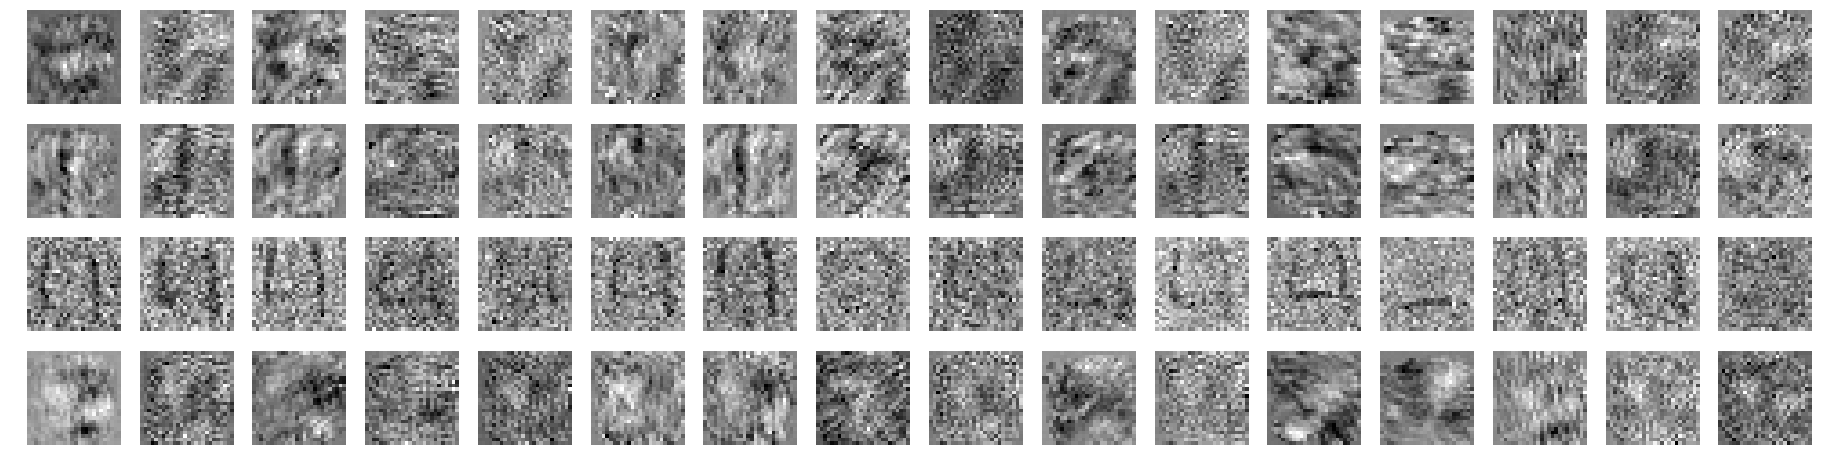

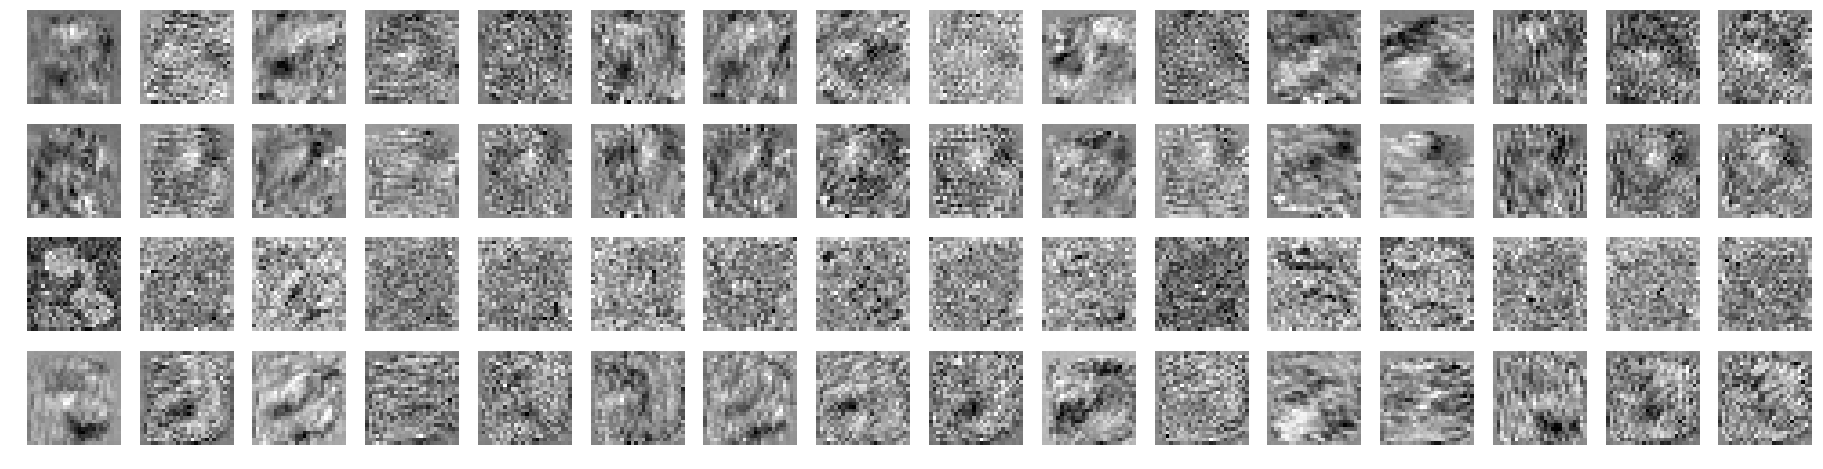

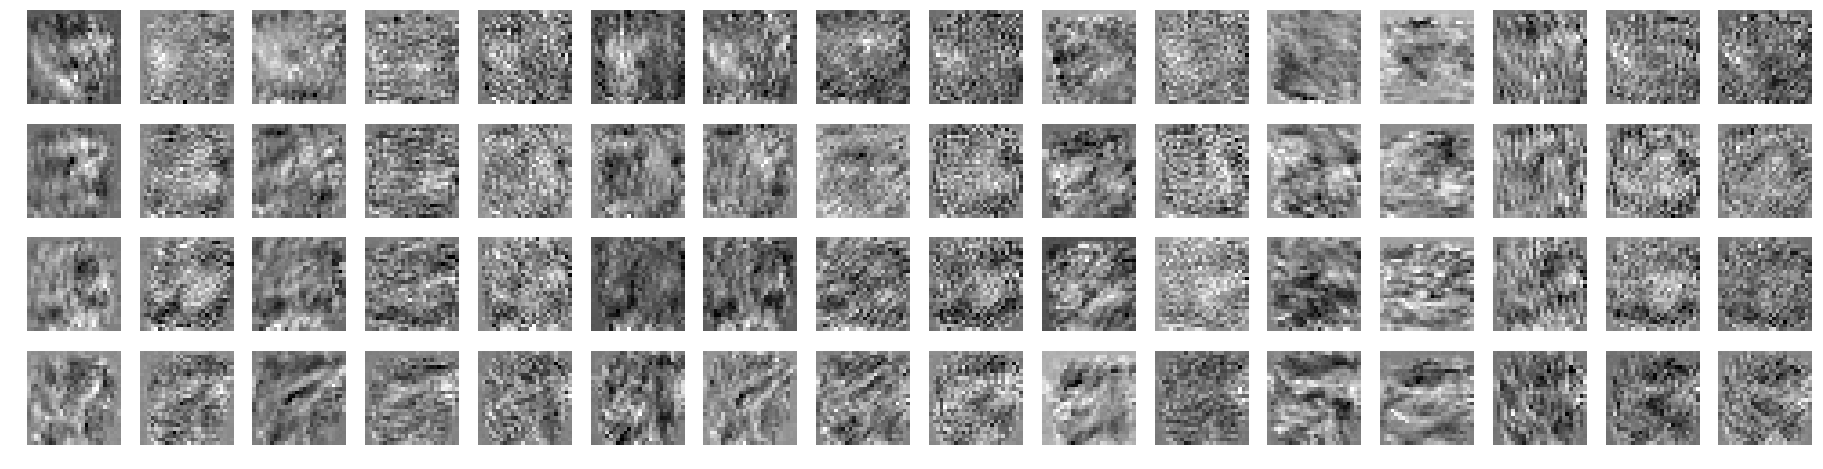

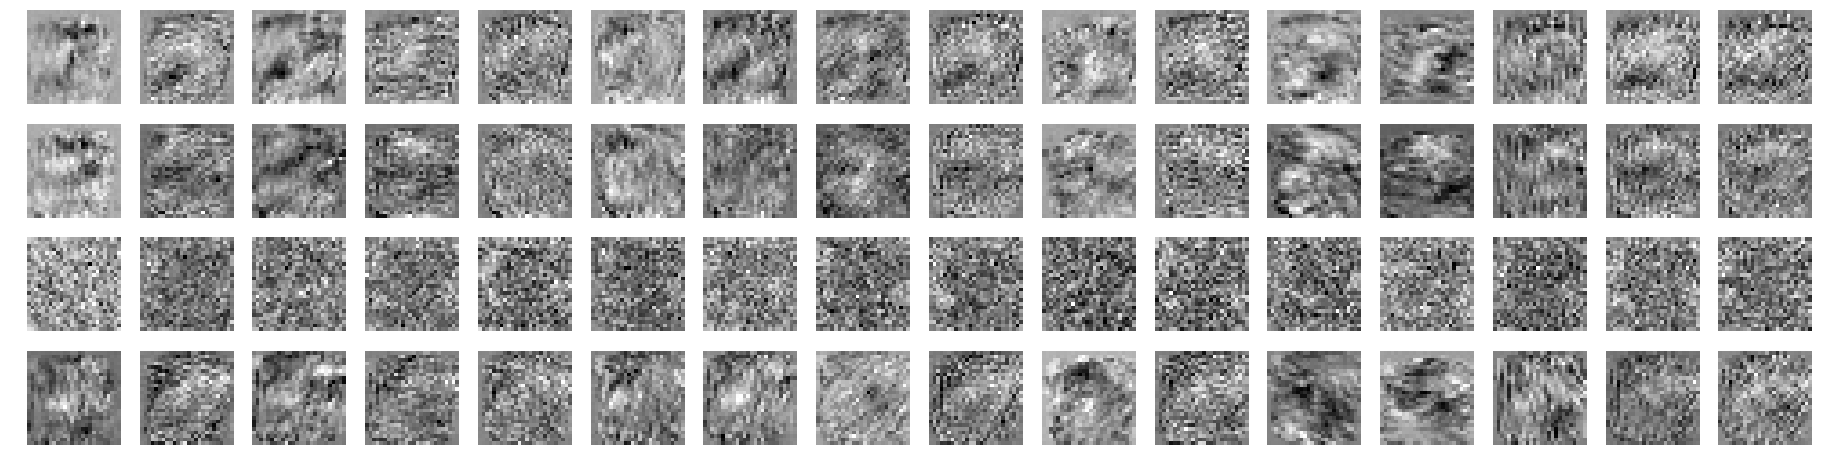

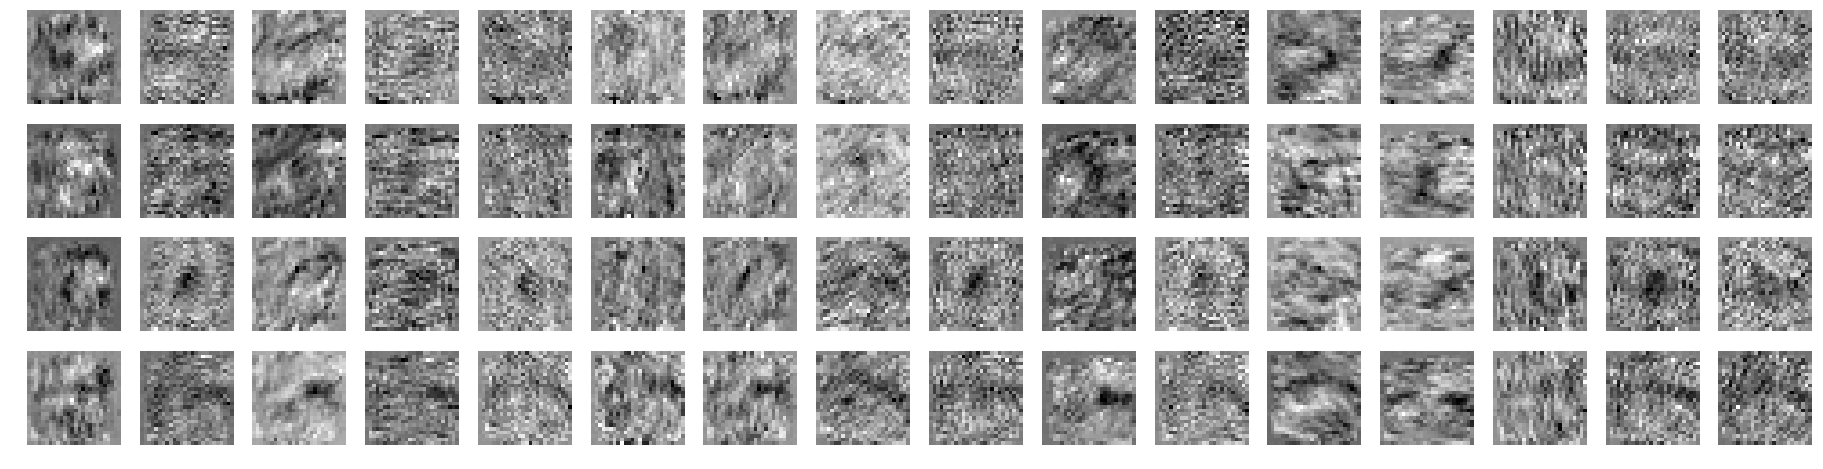

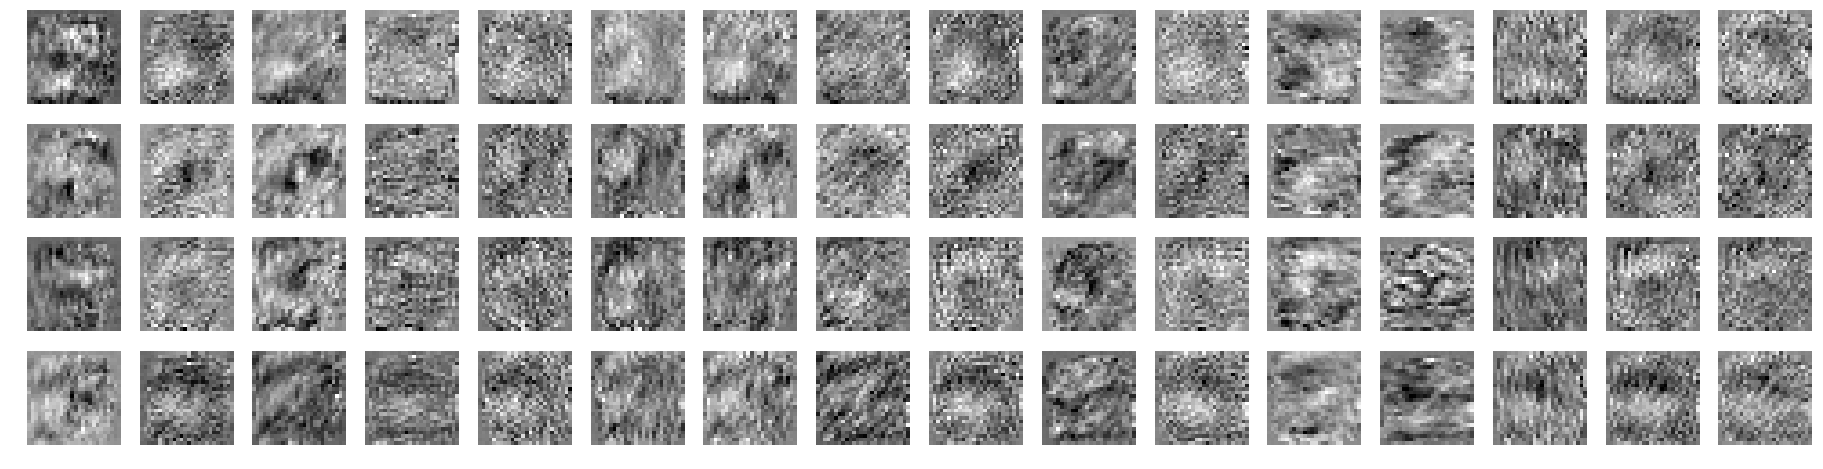

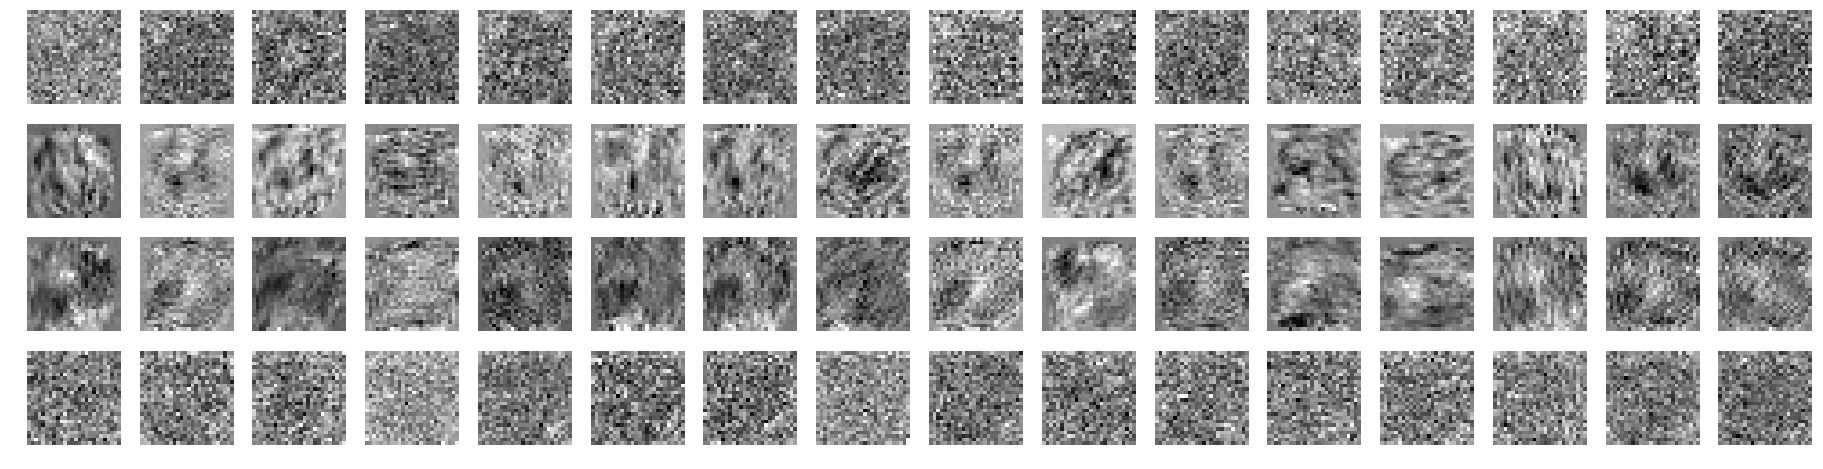

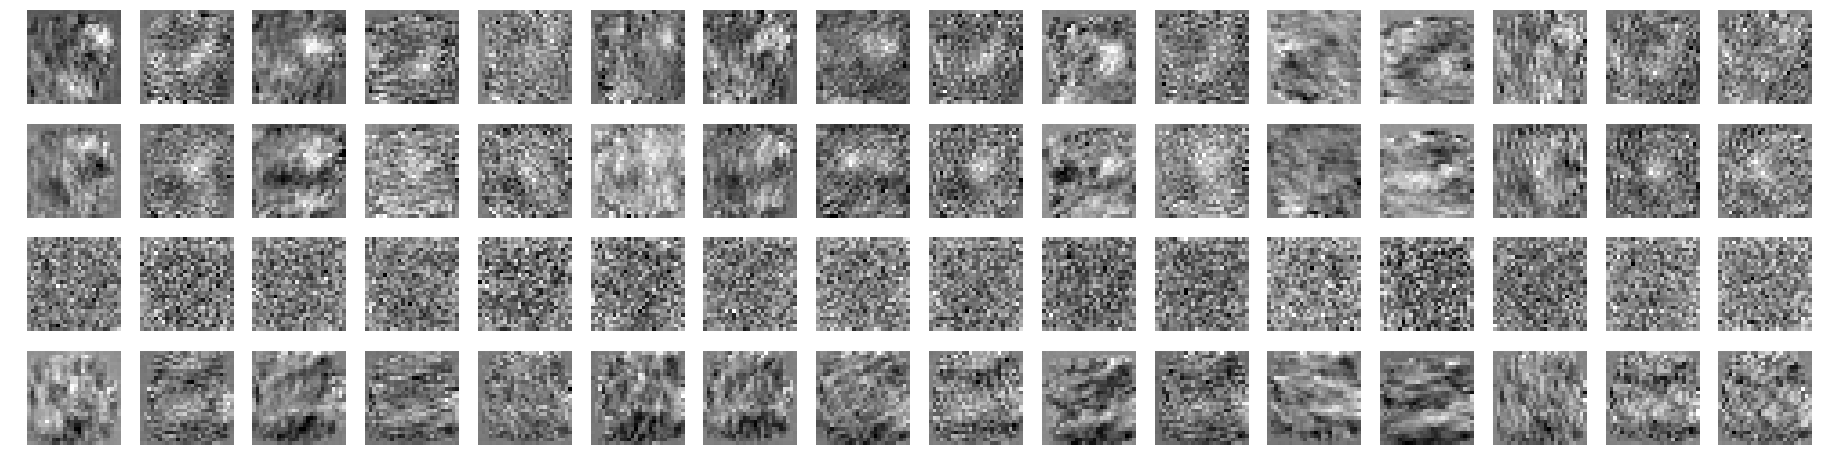

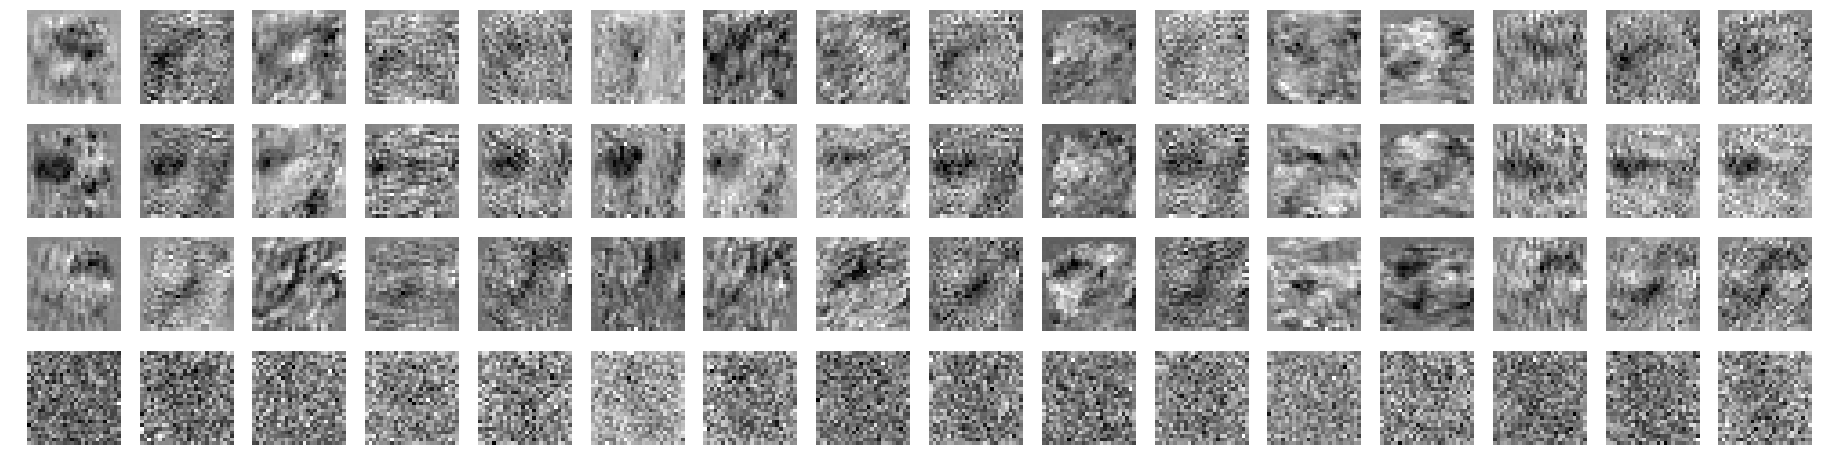

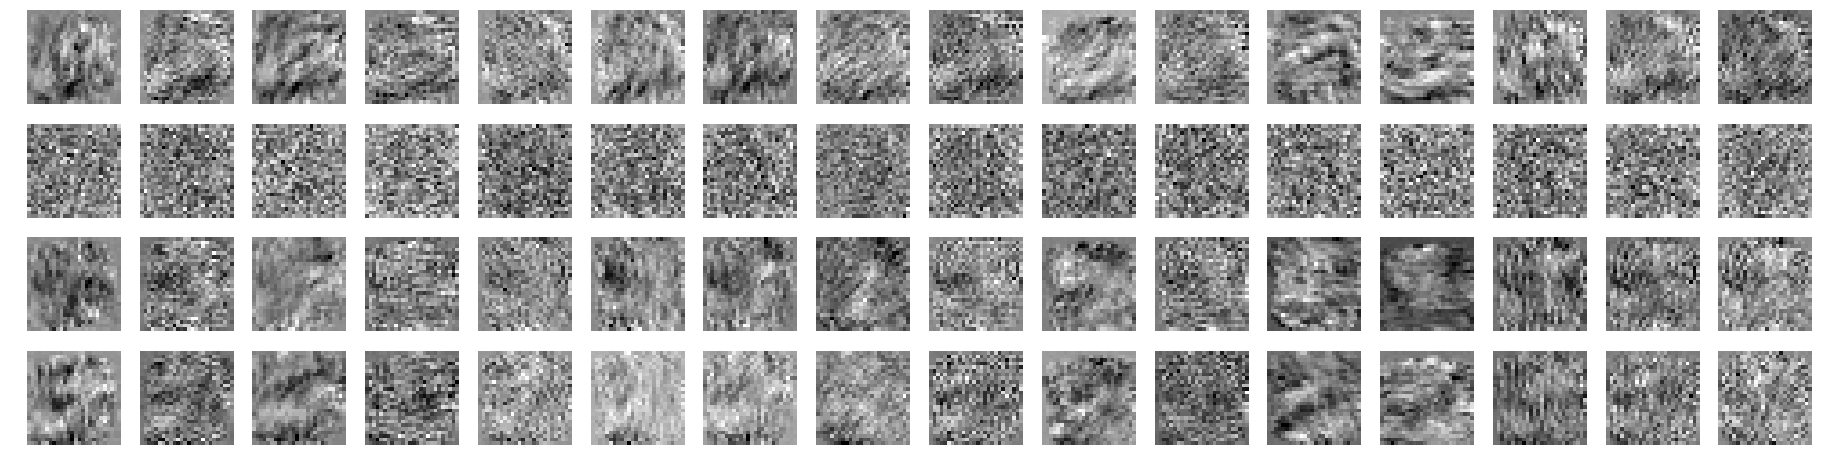

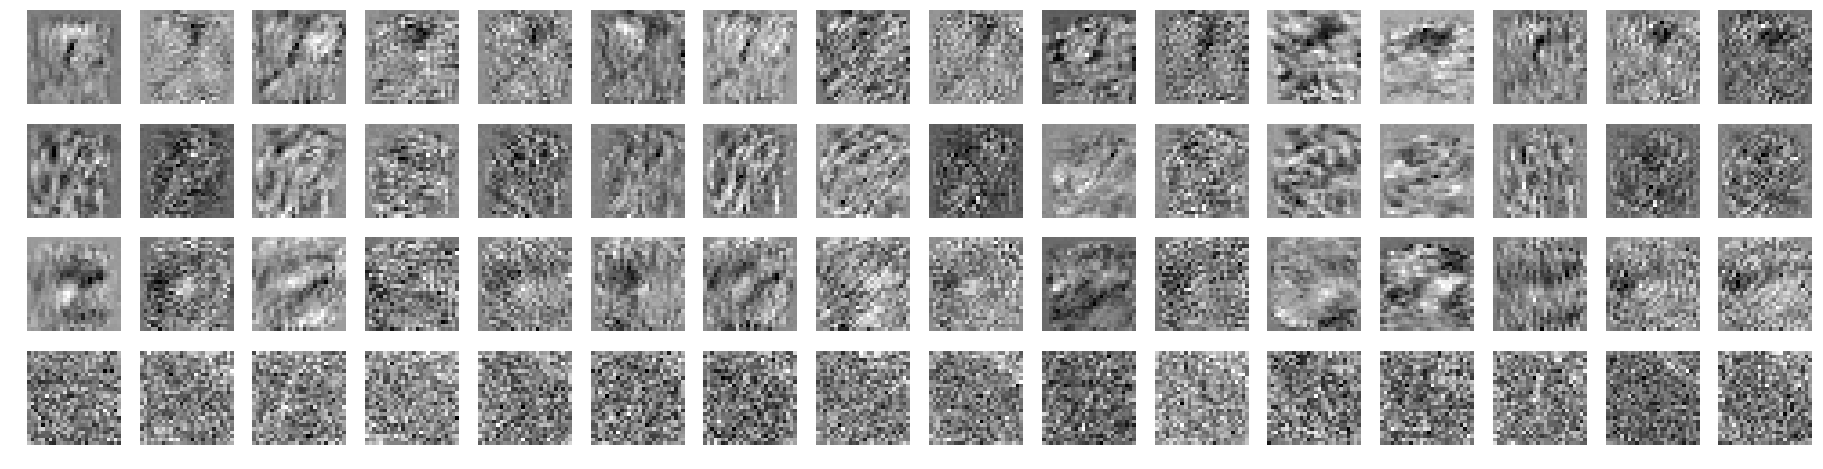

26


In [52]:
n_row = 2
n_col = 2
for i in range(1, n_specific+2):
    plt.figure(figsize=(n_channel*2, n_row*n_col*2))
    for j in range(int(n_row*n_col)):
        w_data = van_mlp.l1.W.data[int(n_col*n_row*(i-1) + j)].reshape(n_channel, -1)
        w = int(np.sqrt(w_data.shape[1]))
        for k in range(n_channel):
            plt.subplot(n_row*n_col, n_channel, n_channel*j+k+1)
            plt.imshow(w_data[k].reshape(w, w), cmap='gray')
            plt.axis('off')
    plt.savefig(os.path.join(van_root, 'l1_weights_{}.png'.format(i-2)))
    plt.show()
print(w)

In [53]:
sep_root = './sep_result_2Layer_all_class'

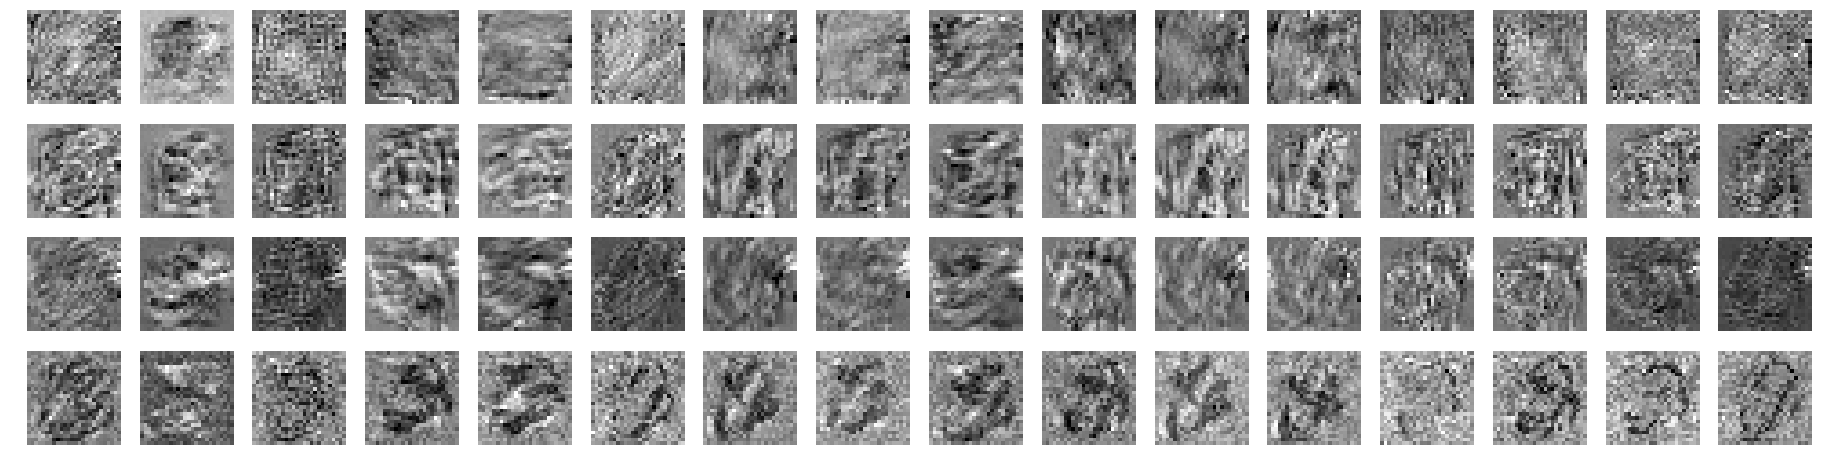

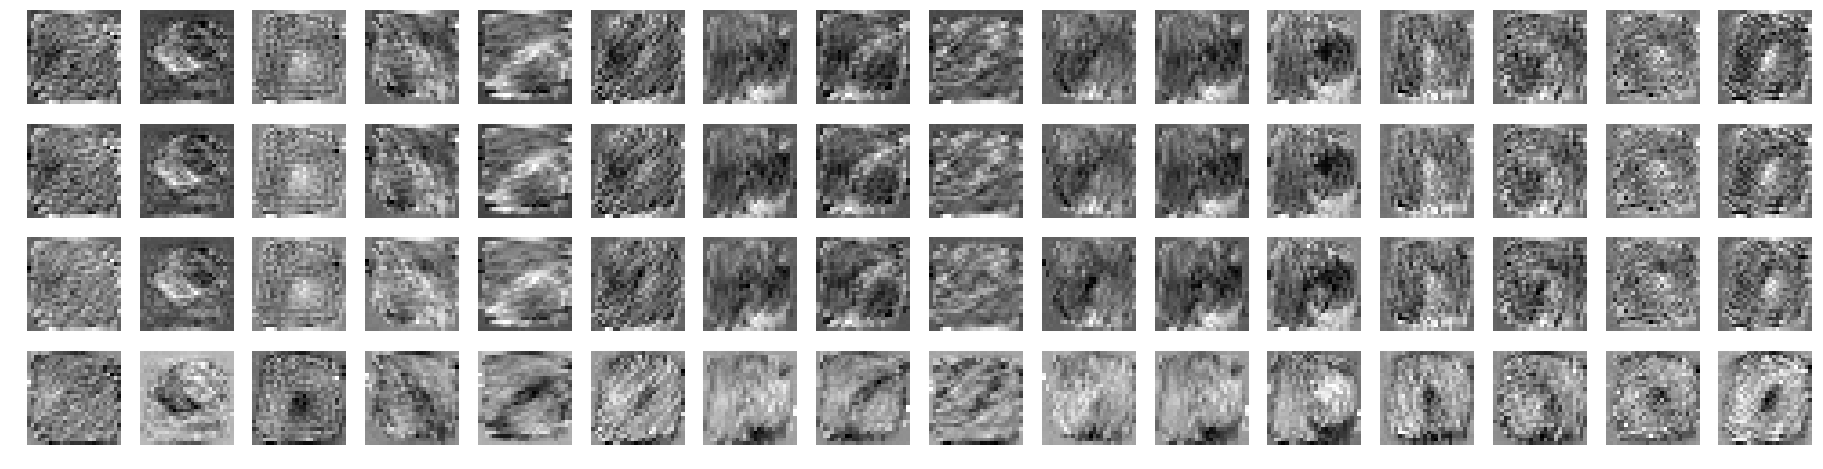

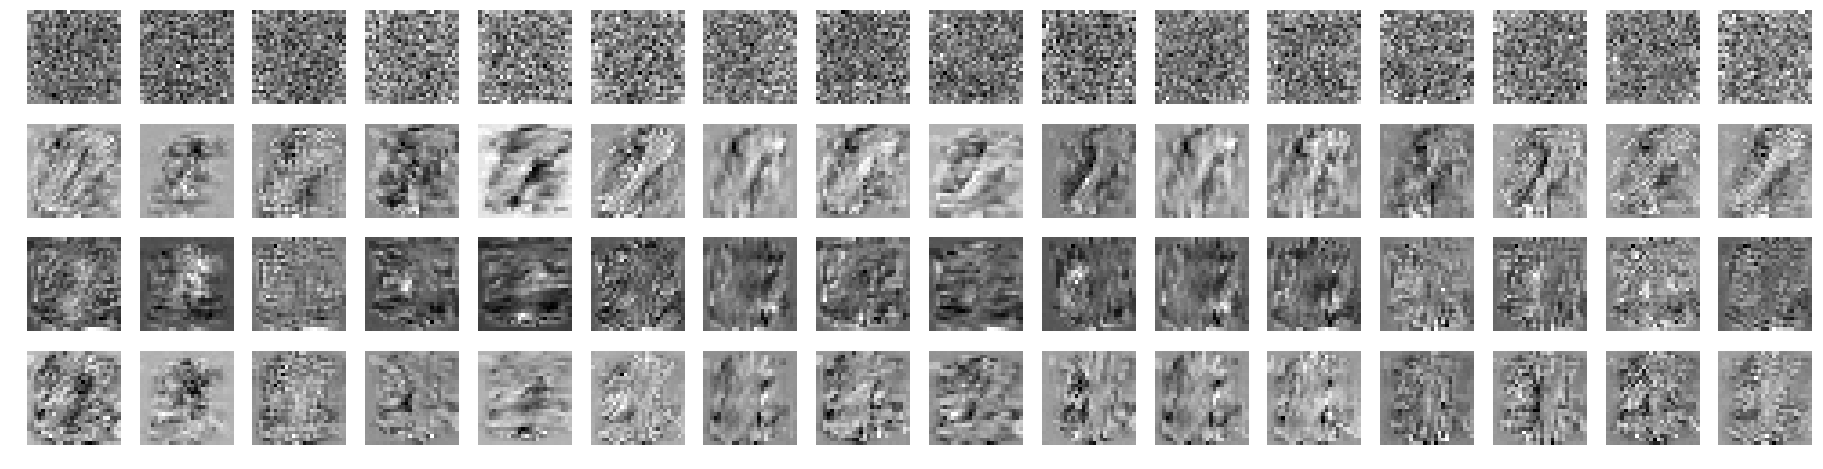

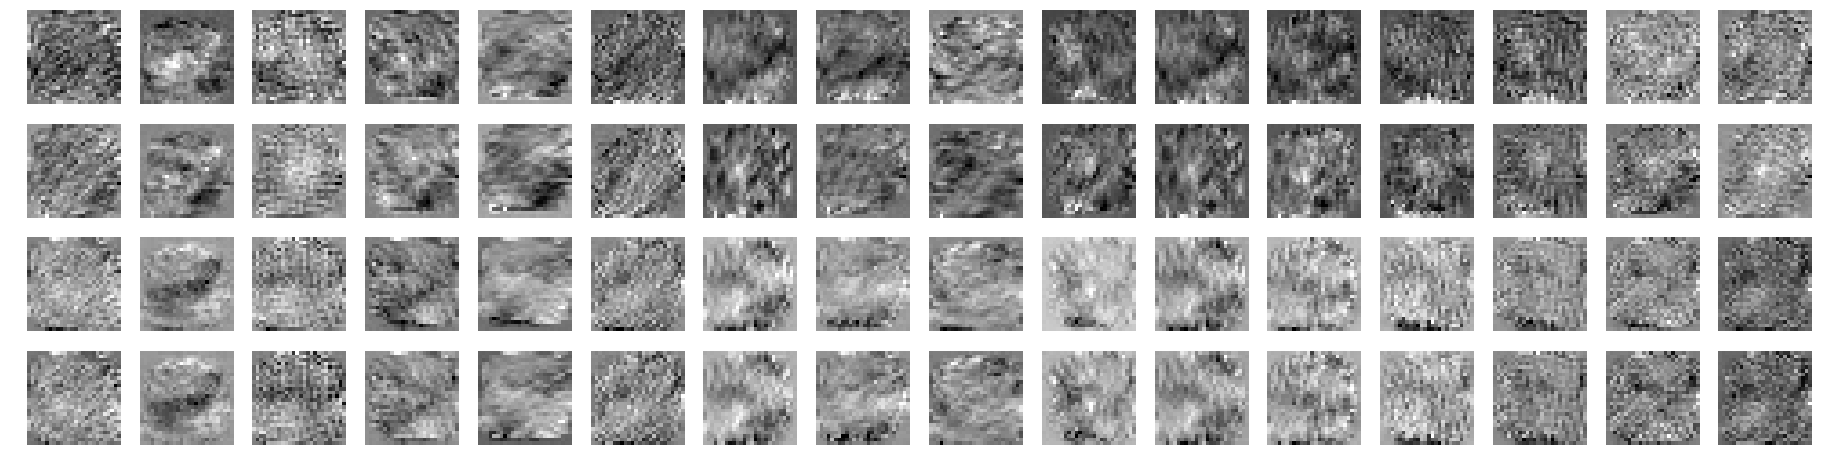

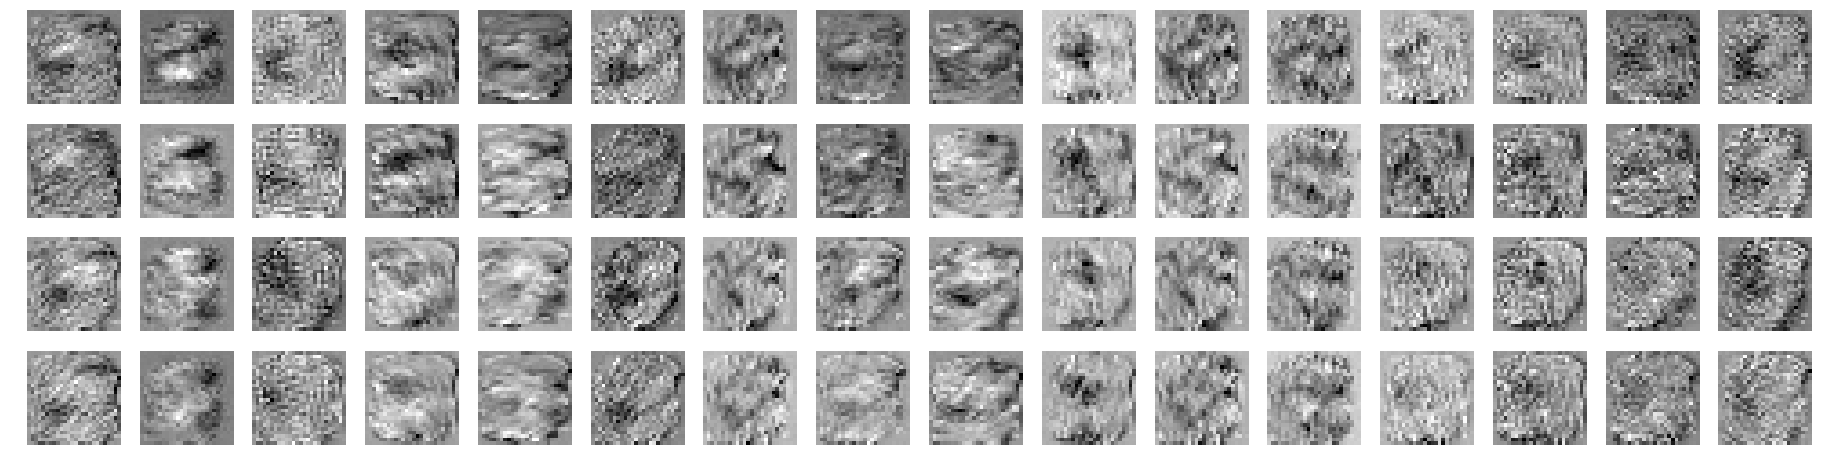

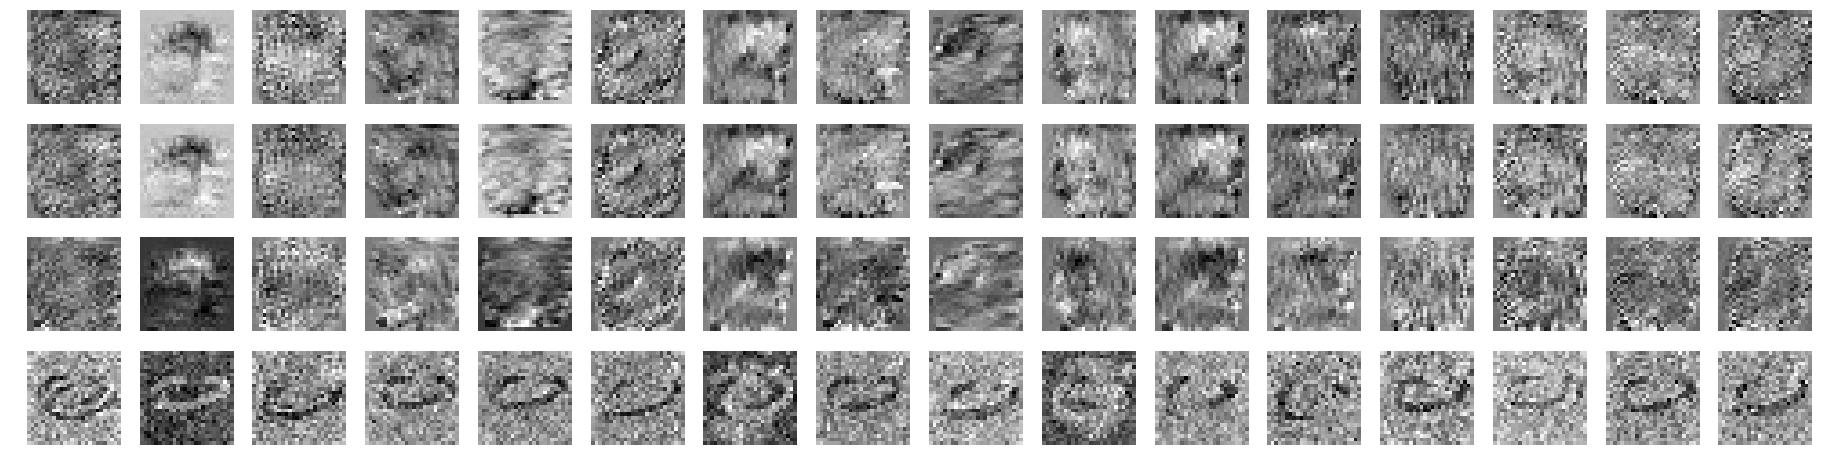

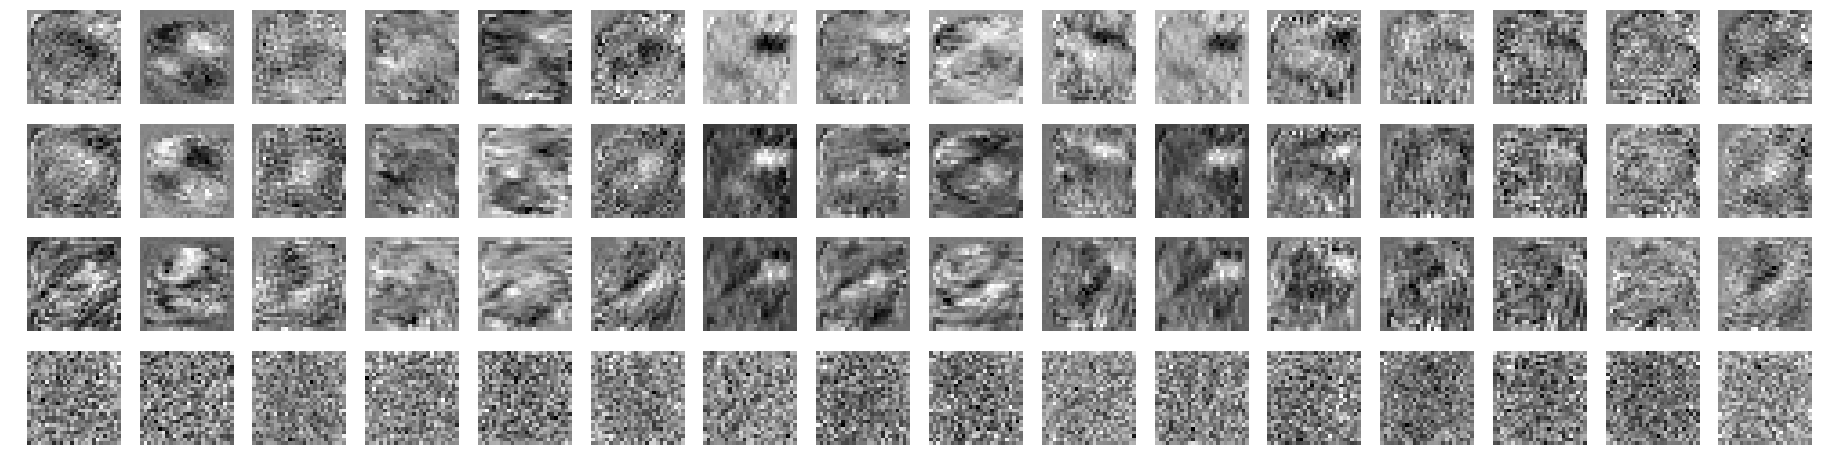

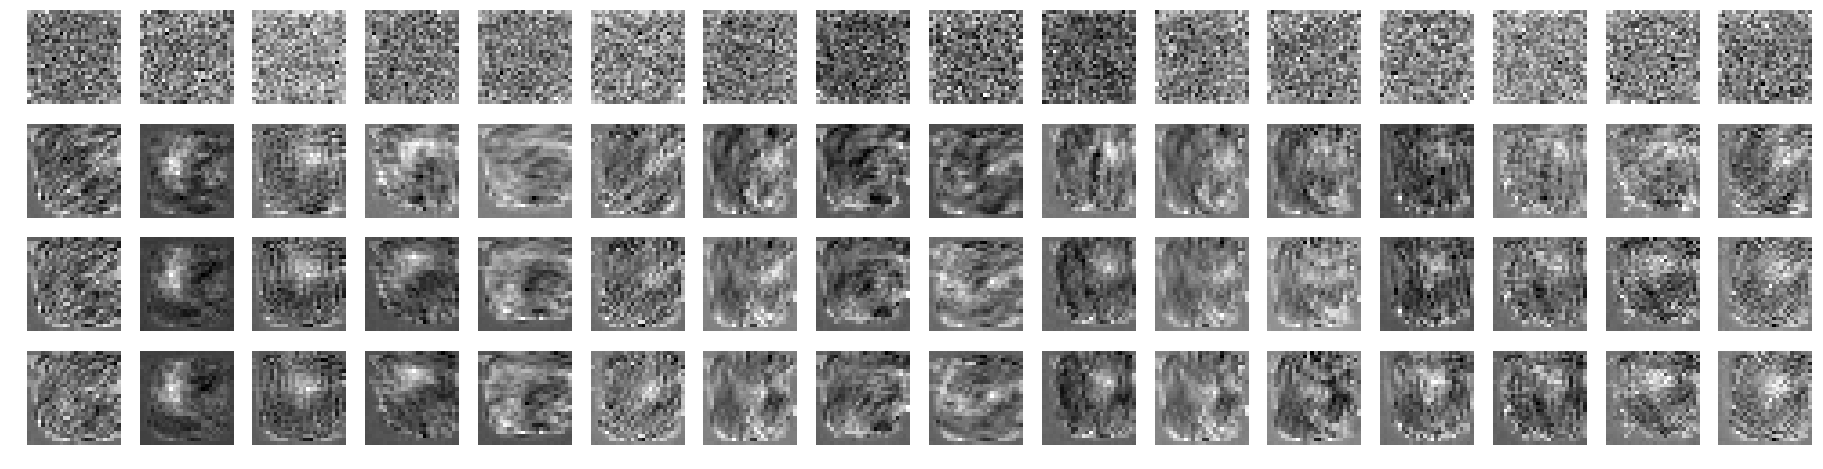

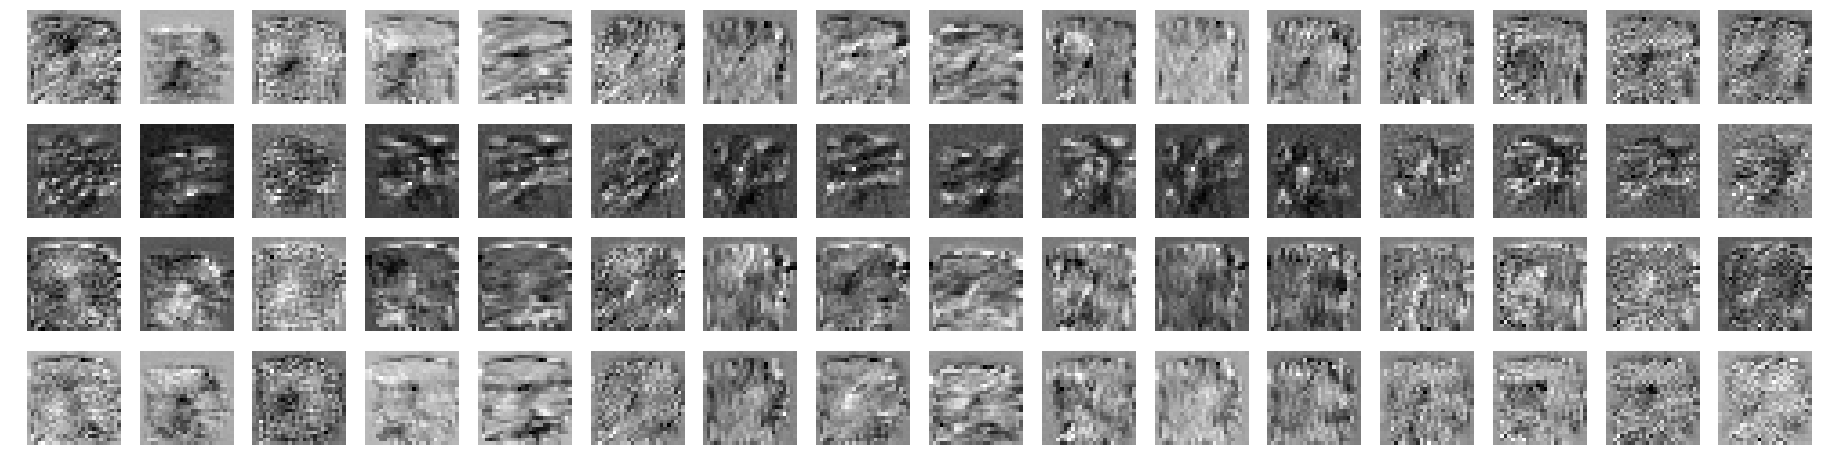

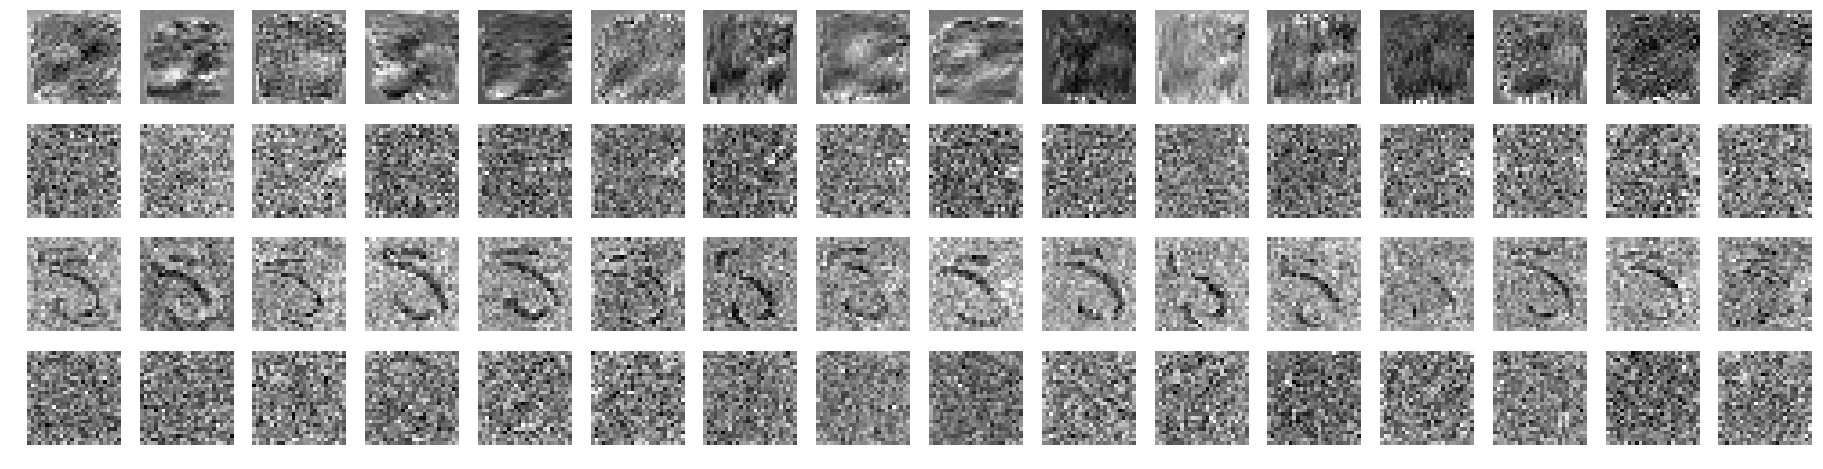

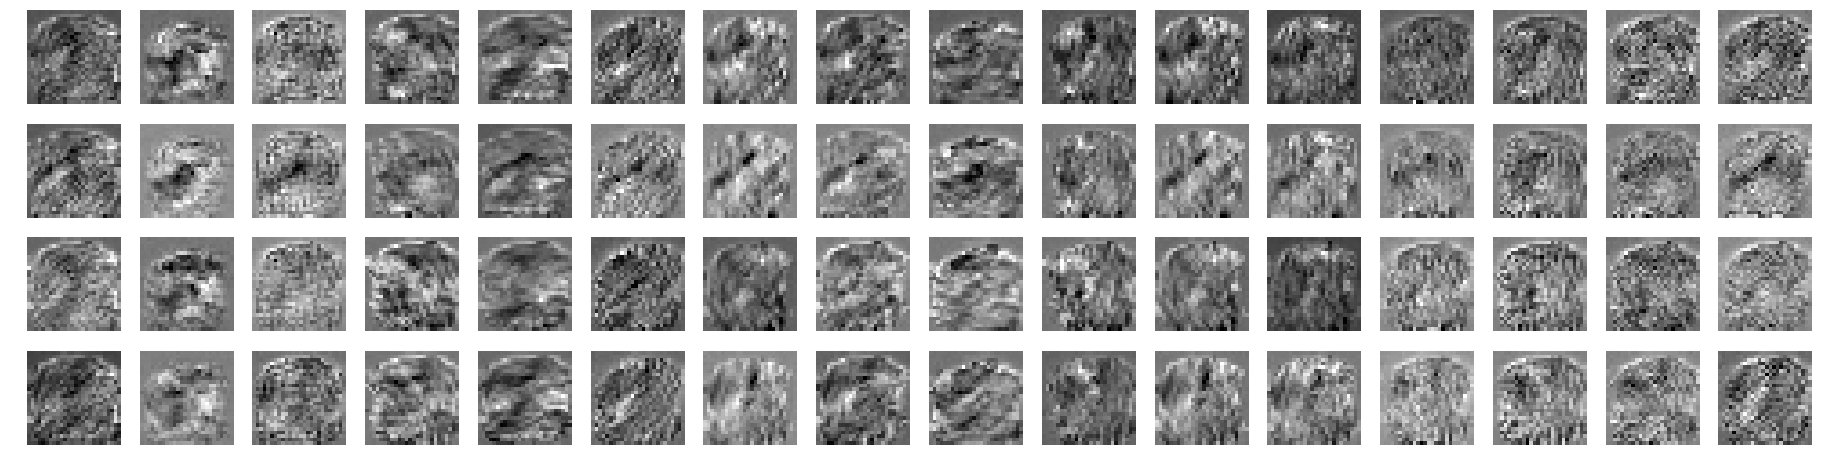

In [54]:
n_row = 2
n_col = 2
for i in range(1, n_specific+2):
    plt.figure(figsize=(n_channel*2, n_col*n_row*2))
    for j in range(int(n_row*n_col)):
        for k in range(n_channel):
            plt.subplot(n_row*n_col, n_channel, n_channel*j+k+1)
            w_data = sep_mlp.l1[i-1].W.data[int(j)].reshape(n_channel, -1)
            plt.imshow(w_data[k].reshape(w, w), cmap='gray')
            plt.axis('off')
    plt.savefig(os.path.join(sep_root, 'l1_weights_{}.png'.format(i-2)))
    plt.show()

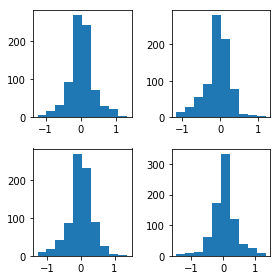

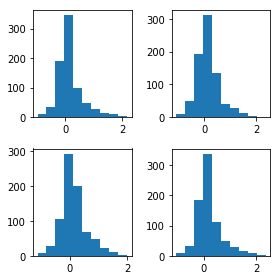

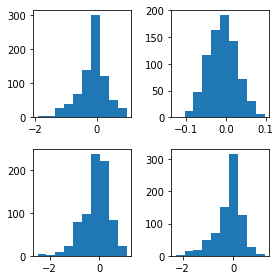

In [49]:
n_row = 2
n_col = 2
for i in range(1, 3+1):
    plt.figure(figsize=(n_row*2, n_col*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
#         plt.imshow(van_mlp.l1.W.data[int(i*j)].reshape(28, 28), cmap='gray')
        plt.hist(sep_mlp.l1[i-1].W.data[int(j)])
#         plt.axis('off')
    plt.tight_layout()
    plt.show()

[[ 0.07511211  0.33531988  0.40708542 -0.68301105  0.00328134 -0.68353224
   0.21231079 -1.0464522  -0.9086151  -0.8725519  -0.4447089   0.38888735
  -0.7736789  -1.0607717   0.14264907  0.58373135  0.57107544  0.6682275
   0.4980798   0.69106174  0.29699603 -0.7963526   0.36554676  0.3125569
   0.7543513   0.01029655 -1.3206228  -1.6611751   0.10166971  0.1588697
  -0.5953785  -1.9610044   0.14823233 -0.888133    0.5102823   0.6501202
  -0.17094052 -0.17793491 -0.49797457 -1.161644   -0.4852531  -0.91022396
   0.00591887 -0.14262256]
 [-0.90086365  0.45420754 -0.35489154  0.97859913  0.22747114 -0.52779496
   0.7086523   0.7515534  -0.4587842   0.46605688  0.22349167  0.10608526
   0.11557005  0.5479687  -0.37464646  0.6515495  -1.5335735  -0.23404586
  -0.5106779   0.9967213   0.01650159 -1.1066607  -0.03073386 -0.98250425
   0.78447145 -0.23993245  0.49877933  1.245224   -0.20851888 -0.1936512
  -0.07824962  0.27488235 -0.41445112 -0.03139648  0.947627    0.78036827
  -1.4235144   0

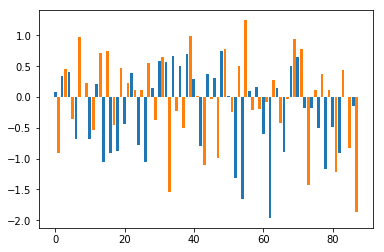

In [51]:
print(van_mlp.out.W.data)
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2+1, van_mlp.out.W.data[1])
plt.show()

[[ 1.0835652   0.2627686   0.2597404   0.65377265 -1.1378077  -1.2105938
  -1.9634953  -0.85829264]]


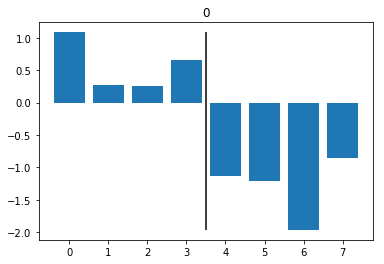

[[-0.04425191  0.6031764  -1.0220748   0.00788897  1.7333212   0.7146446
   2.0009592   1.6573801 ]]


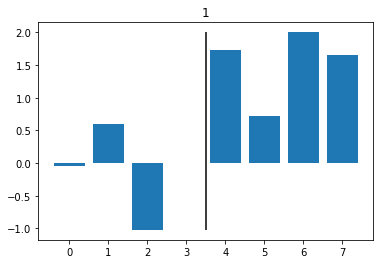

[[ 0.22923388 -0.14085384 -0.8324088   0.15716775  2.3785477   1.3899862
   1.8260113   1.846473  ]]


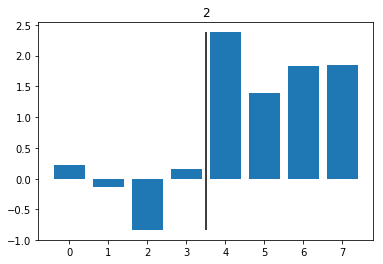

[[-0.5598392 -1.2951247 -0.1702604 -0.8759753 -2.0772948  0.9704017
   1.9808725  2.171578 ]]


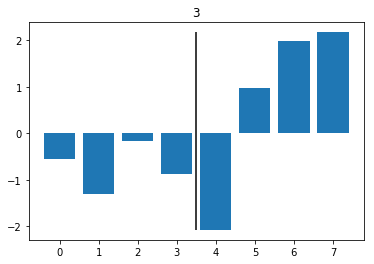

[[ 1.0126594   0.10185392  0.21259965  0.28122956  1.3860918  -1.3819785
  -2.7827904   2.3096426 ]]


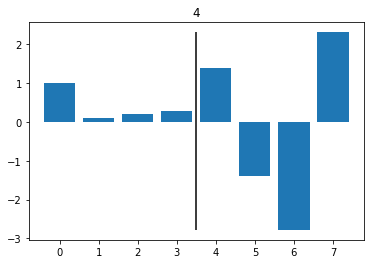

[[-0.23063913 -1.3796984   0.0237442  -0.44115475 -2.018855   -2.3253822
  -2.5125465   0.9820449 ]]


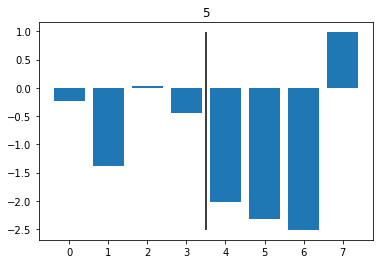

[[-0.4820222  -0.05065047 -0.5454165   1.014242   -1.9965922   0.89692473
   1.3868353   0.2370416 ]]


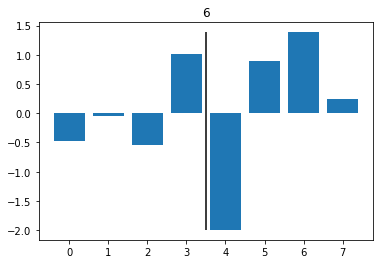

[[ 0.7648511  -0.45696965  0.04259017  1.4184759  -1.3642106  -2.2189317
   1.8036648  -1.5768167 ]]


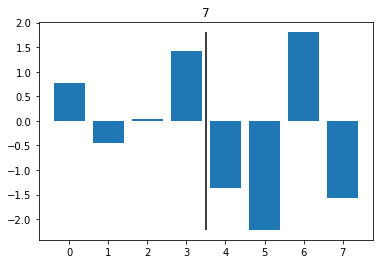

[[-1.738357    0.9896472   0.4054536  -0.02392689  0.8051083   0.1045567
   0.54708385 -2.0641348 ]]


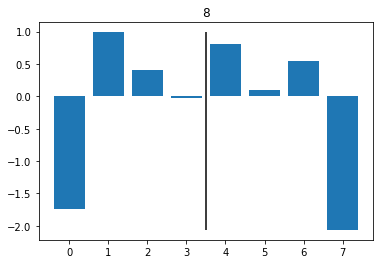

[[ 0.6547204  -1.2585914   0.9356145   0.03794168 -1.6572158  -1.822533
   1.8443506  -0.9156971 ]]


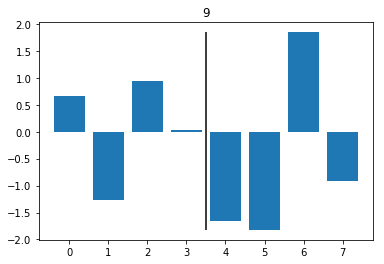

In [54]:
for i in range(n_specific):
    print(sep_mlp.out[i].W.data)
    plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
    ymax = sep_mlp.out[i].W.data.max()
    ymin = sep_mlp.out[i].W.data.min()
    plt.title(i)
    plt.vlines(n_col*n_row - .5 , ymin=ymin, ymax=ymax)
    plt.show()

In [20]:
sep_mlp.out[1].W

variable W([[ 0.2536435 ,  0.25699794, -0.35537377,  0.8589217 ,
             -0.34231865,  0.3147955 ,  0.2837925 , -0.22916302,
             -0.65419525,  0.2821943 , -0.3133061 , -0.34953964,
             -0.5245345 ,  0.613856  , -0.3837532 , -0.7158491 ,
             -0.29600126,  0.2790813 ]])